# Step 3 — Modeling & Evaluation (BankChurners)

**Purpose.** Train calibrated churn models and evaluate with decision-ready metrics:
- Baseline: **Logistic Regression** (interpretable, fast)
- Stronger: **Gradient Boosted Trees (XGBoost)**
- **Metrics:** ROC-AUC, PR-AUC, Brier Score (probability quality)
- **Curves:** ROC, Precision–Recall, **Calibration (reliability)**
- **Business lens:** **Lift / Gains** (top-decile targeting)
- **Explainability:** SHAP global importance

I’ll also **persist test-set scores** for Step 4 (ROI targeting curve + sensitivity).

In [11]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from joblib import load, dump

# Optional strong model
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

BASE = Path("..")
PROC = BASE / "data" / "processed"
MODELS = BASE / "models"
OUT = BASE / "outputs"

PROC.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)
OUT.mkdir(parents=True, exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


## Load data & preprocessing artifacts

- Use `bankchurners_processed.csv` (Step 1).
- If `train.csv` / `test.csv` from Step 2 exist, load them; otherwise recreate the split (stratified).
- If `preprocessor.joblib` exists, load it; otherwise fit it on the training data (so the notebook is reproducible).


In [12]:
df = pd.read_csv(PROC / "bankchurners_processed.csv")
assert "churn" in df.columns, "Target 'churn' missing."

# Keep id for joins/visuals, but not as a feature
id_col = "id" if "id" in df.columns else None

# Column manifests (created in Step 2). If missing, rebuild conservative lists.
try:
    cat_cols = json.loads((PROC / "cat_cols.json").read_text())
    num_cols = json.loads((PROC / "num_cols.json").read_text())
except FileNotFoundError:
    cat_candidates = ["gender","education_level","marital_status","income_category","card_category","util_band"]
    num_candidates = [
        "customer_age","dependent_count","months_on_book","total_relationship_count",
        "months_inactive_12_mon","contacts_count_12_mon",
        "credit_limit","total_revolving_bal","avg_open_to_buy",
        "total_amt_chng_q4_q1","total_trans_amt","total_trans_ct",
        "total_ct_chng_q4_q1","avg_utilization_ratio",
        "avg_trans_amt","trans_per_month","contact_rate_12m","inactive_3plus_12m"
    ]
    cat_cols = [c for c in cat_candidates if c in df.columns]
    num_cols = [c for c in num_candidates if c in df.columns]

use_cols = ([id_col] if id_col else []) + ["churn"] + cat_cols + num_cols
data = df[use_cols].copy()

# Prefer deterministic split files from Step 2
train_path, test_path = PROC / "train.csv", PROC / "test.csv"
if train_path.exists() and test_path.exists():
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
else:
    # Recreate split if needed
    X = data.drop(columns=["churn"])
    y = data["churn"].astype(int).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    train_df = X_train.copy(); train_df["churn"] = y_train
    test_df  = X_test.copy();  test_df["churn"]  = y_test

print("Train/Test shapes:", train_df.shape, test_df.shape)
print("Train churn rate:", train_df["churn"].mean().round(3), 
      "| Test churn rate:", test_df["churn"].mean().round(3))


Train/Test shapes: (7595, 26) (2532, 26)
Train churn rate: 0.161 | Test churn rate: 0.161


In [13]:
pre_path = MODELS / "preprocessor.joblib"
if pre_path.exists():
    pre = load(pre_path)
    print("Loaded preprocessor:", pre_path)
else:
    pre = ColumnTransformer(
        [("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), cat_cols),
         ("num", StandardScaler(), num_cols)],
        remainder="drop"
    )
    pre.fit(train_df.drop(columns=["churn"]))
    dump(pre, pre_path)
    print("Fitted & saved preprocessor:", pre_path)

# Encoded feature names
try:
    feature_names = json.loads((MODELS / "feature_names.json").read_text())
except FileNotFoundError:
    ohe = pre.named_transformers_["cat"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
    feature_names = ohe_names + num_cols
    (MODELS / "feature_names.json").write_text(json.dumps(feature_names, indent=2))

len(feature_names), feature_names[:8]


Loaded preprocessor: ../models/preprocessor.joblib


(45,
 ['gender_M',
  'education_level_College',
  'education_level_Doctorate',
  'education_level_Graduate',
  'education_level_High School',
  'education_level_Post-Graduate',
  'education_level_Uneducated',
  'education_level_Unknown'])

## Baseline model — Logistic Regression

**Why start here?** It’s fast, well-calibrated (often), and sets a clear baseline.
- `class_weight="balanced"` to handle class imbalance
- Train on **train set** only; evaluate on **test set**
- We report: **ROC-AUC**, **PR-AUC** (better for imbalance), **Brier** (probability calibration)


In [14]:
y_train = train_df["churn"].astype(int).values
y_test  = test_df["churn"].astype(int).values
X_train = train_df.drop(columns=["churn"])
X_test  = test_df.drop(columns=["churn"])

logit = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None))
])
logit.fit(X_train, y_train)

p_tr = logit.predict_proba(X_train)[:,1]
p_te = logit.predict_proba(X_test)[:,1]

metrics = {
    "ROC_AUC_train": roc_auc_score(y_train, p_tr),
    "ROC_AUC_test":  roc_auc_score(y_test,  p_te),
    "PR_AUC_test":   average_precision_score(y_test, p_te),
    "Brier_test":    brier_score_loss(y_test, p_te),
}
metrics


{'ROC_AUC_train': 0.9413504339440695,
 'ROC_AUC_test': 0.9344067061714121,
 'PR_AUC_test': 0.762119129078335,
 'Brier_test': 0.09395831214400935}

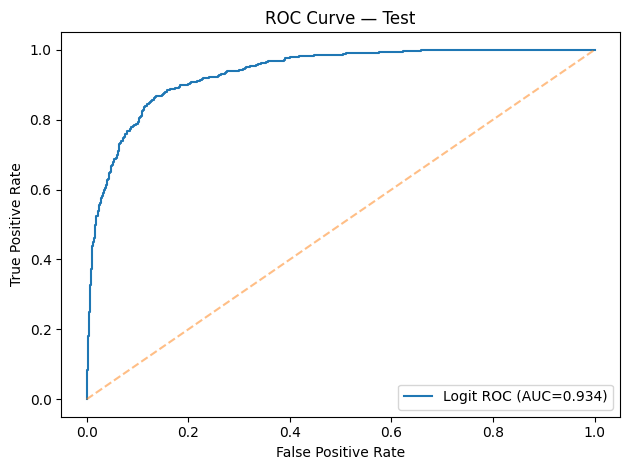

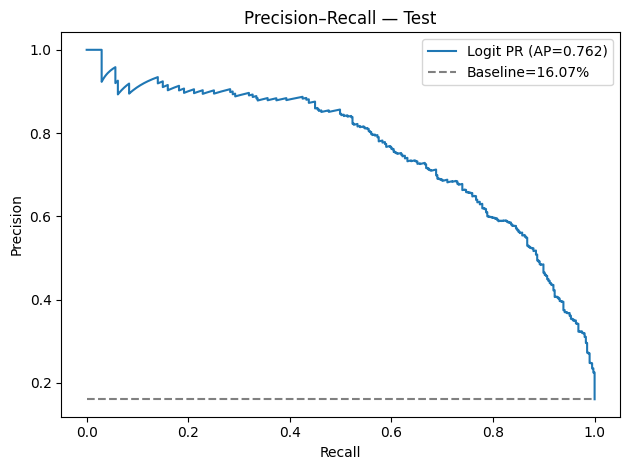

In [15]:
# ROC
fpr, tpr, _ = roc_curve(y_test, p_te)
plt.figure()
plt.plot(fpr, tpr, label=f"Logit ROC (AUC={metrics['ROC_AUC_test']:.3f})")
plt.plot([0,1],[0,1],'--',alpha=.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test"); plt.legend(); plt.tight_layout()
plt.savefig(OUT / "churn_roc_logit.png", dpi=150); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, p_te)
base = y_test.mean()
plt.figure()
plt.plot(rec, prec, label=f"Logit PR (AP={metrics['PR_AUC_test']:.3f})")
plt.hlines(base, 0, 1, colors="gray", linestyles="--", label=f"Baseline={base:.2%}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — Test"); plt.legend(); plt.tight_layout()
plt.savefig(OUT / "churn_pr_logit.png", dpi=150); plt.show()


## Probability calibration (reliability curve)

We check how well predicted probabilities match observed churn rates.  
Good calibration is critical when you convert probabilities into **profit-based decisions**.

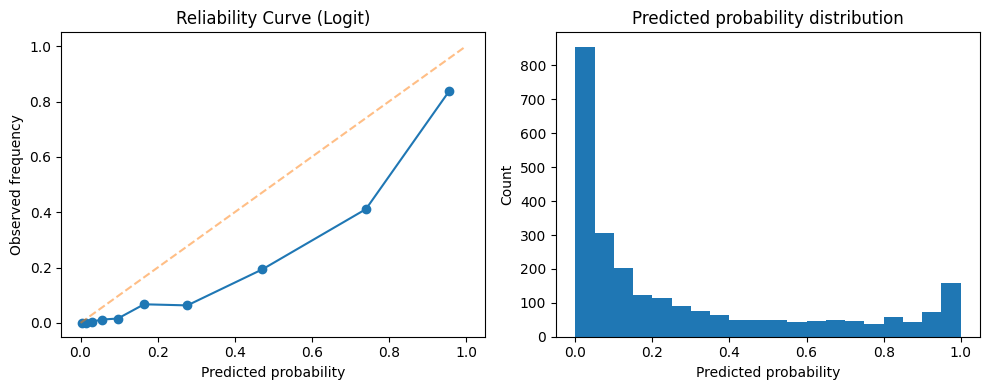

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, p_te, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(1,2, figsize=(10,4))
# Reliability
ax[0].plot(prob_pred, prob_true, marker="o")
ax[0].plot([0,1],[0,1],'--',alpha=.5)
ax[0].set_title("Reliability Curve (Logit)")
ax[0].set_xlabel("Predicted probability"); ax[0].set_ylabel("Observed frequency")

# Histogram of predicted probs
ax[1].hist(p_te, bins=20)
ax[1].set_title("Predicted probability distribution")
ax[1].set_xlabel("Predicted probability"); ax[1].set_ylabel("Count")

plt.tight_layout(); plt.savefig(OUT / "churn_calibration_logit.png", dpi=150); plt.show()


## Gradient Boosted Trees (XGBoost)

Tree ensembles usually capture **non-linearities and interactions** (e.g., utilization × inactivity).  
We keep sensible defaults to avoid overfitting; the goal is a **clean, defensible** model, not leaderboard tuning.


{'ROC_AUC_test': 0.9931990171990172, 'PR_AUC_test': 0.9660820827193468, 'Brier_test': 0.023139919727269437}


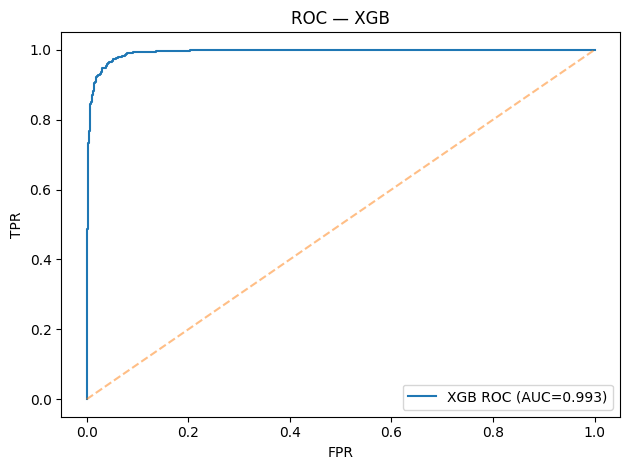

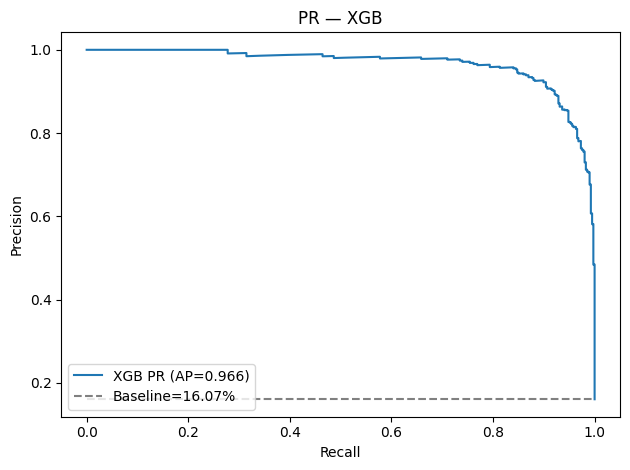

In [17]:
if HAS_XGB:
    xgb = Pipeline([
        ("pre", pre),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            eval_metric="logloss", n_jobs=-1, random_state=42
        ))
    ])
    xgb.fit(X_train, y_train)

    p_te_xgb = xgb.predict_proba(X_test)[:,1]
    m_xgb = {
        "ROC_AUC_test": roc_auc_score(y_test, p_te_xgb),
        "PR_AUC_test":  average_precision_score(y_test, p_te_xgb),
        "Brier_test":   brier_score_loss(y_test, p_te_xgb),
    }
    print(m_xgb)

    # Curves
    fpr, tpr, _ = roc_curve(y_test, p_te_xgb)
    plt.figure(); plt.plot(fpr, tpr, label=f"XGB ROC (AUC={m_xgb['ROC_AUC_test']:.3f})")
    plt.plot([0,1],[0,1],'--',alpha=.5); plt.legend()
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — XGB"); plt.tight_layout()
    plt.savefig(OUT / "churn_roc_xgb.png", dpi=150); plt.show()

    prec, rec, _ = precision_recall_curve(y_test, p_te_xgb)
    base = y_test.mean()
    plt.figure(); plt.plot(rec, prec, label=f"XGB PR (AP={m_xgb['PR_AUC_test']:.3f})")
    plt.hlines(base, 0, 1, colors="gray", linestyles="--", label=f"Baseline={base:.2%}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — XGB"); plt.legend(); plt.tight_layout()
    plt.savefig(OUT / "churn_pr_xgb.png", dpi=150); plt.show()
else:
    print("XGBoost not installed — skipping strong model. (pip install xgboost shap)")


## Calibrate the best model (optional, improves decisioning)

If the tree model’s probabilities look miscalibrated, apply **isotonic** calibration on cross-validation folds.
We’ll use this calibrated output in Step 4 (profit thresholding).

In [18]:
from sklearn.base import is_classifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# 1) Build a known-good classifier pipeline if needed
def make_logit(pre):
    return Pipeline([("pre", pre),
                     ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])

def make_gbm(pre):
    return Pipeline([("pre", pre),
                     ("clf", HistGradientBoostingClassifier(
                         learning_rate=0.08, max_depth=6, max_bins=255, random_state=42
                     ))])

# 2) Ensure best_pipe is a classifier
try:
    candidate = xgb if HAS_XGB else logit
except NameError:
    candidate = None

if candidate is None or not is_classifier(candidate):
    # Fallback to a fresh Logistic if your variable wiring is off
    print("Best pipe is missing or not a classifier — falling back to Logistic.")
    candidate = make_logit(pre)

# Extra guard: if the final step is not a classifier, rebuild
final_step = type(candidate.named_steps["clf"]).__name__
if "Regressor" in final_step:
    print(f"Found regressor ({final_step}); rebuilding as classifier (GBM).")
    candidate = make_gbm(pre)

# 3) Fit (or refit) the candidate on train
candidate.fit(X_train, y_train)

# 4) Calibrate with isotonic; if you get a fold-size error, switch to sigmoid
try:
    cal = CalibratedClassifierCV(candidate, method="isotonic", cv=3)
    cal.fit(X_train, y_train)
except ValueError as e:
    print("Isotonic calibration failed:", e)
    print("Falling back to sigmoid calibration.")
    cal = CalibratedClassifierCV(candidate, method="sigmoid", cv=3)
    cal.fit(X_train, y_train)

p_te_cal = cal.predict_proba(X_test)[:, 1]

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
cal_metrics = {
    "ROC_AUC_test": roc_auc_score(y_test, p_te_cal),
    "PR_AUC_test":  average_precision_score(y_test, p_te_cal),
    "Brier_test":   brier_score_loss(y_test, p_te_cal),
}
cal_metrics


Best pipe is missing or not a classifier — falling back to Logistic.


{'ROC_AUC_test': 0.9338788842318255,
 'PR_AUC_test': 0.7586861734453924,
 'Brier_test': 0.06859065785157996}

## Lift & Gains (top-decile targeting)

**Why this matters:** Marketers don’t target everyone — they target the **top X% by risk**.  
Lift/Gains curves show how much better the model is than random when you target the top decile(s).

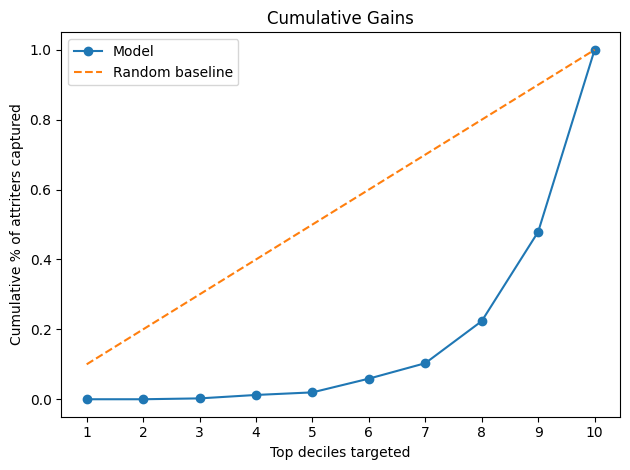

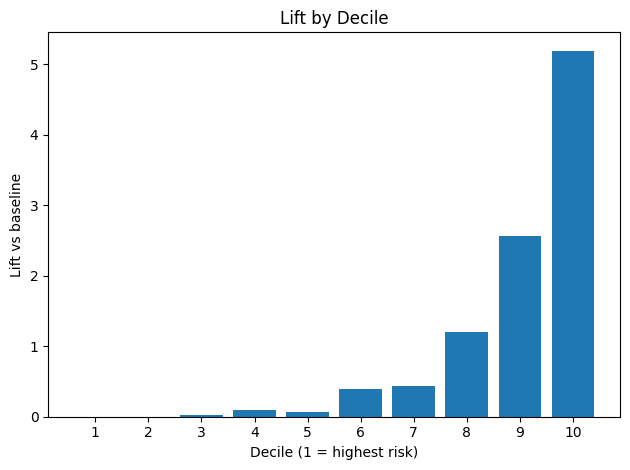

In [27]:
# --- Lift & Gains (top-decile targeting) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pick the calibrated probabilities you computed earlier
probs = pd.Series(p_te_cal if 'p_te_cal' in globals() else (p_te_xgb if 'p_te_xgb' in globals() else p_te), name="p")
truth = pd.Series(y_test, name="y")

# Sort by risk (high->low) and build deciles: 1 = top 10% highest risk
df_gain = (pd.DataFrame({"p": probs, "y": truth})
             .sort_values("p", ascending=False)
             .reset_index(drop=True))
df_gain["decile"] = pd.qcut(np.arange(len(df_gain)), 10, labels=list(range(10, 0, -1)))

# Gains table (pass observed=True to silence the warning, and match the upcoming default)
gain = (df_gain.groupby("decile", observed=True)["y"]
               .agg(["sum", "count"])
               .sort_index(ascending=False)      # keep 10..1 top->bottom
               .reset_index())

# Cumulative gains
gain["cum_pos"]  = gain["sum"].cumsum()
gain["cum_rate"] = gain["cum_pos"] / gain["sum"].sum()

# Plot cumulative gains vs random baseline
plt.figure()
plt.plot(range(1, 11), gain["cum_rate"], marker="o", label="Model")
plt.plot([1, 10], [0.1, 1.0], "--", label="Random baseline")
plt.xticks(range(1, 11)); plt.xlabel("Top deciles targeted")
plt.ylabel("Cumulative % of attriters captured")
plt.title("Cumulative Gains")
plt.legend(); plt.tight_layout()
plt.savefig(OUT / "churn_cumulative_gains.png", dpi=150); plt.show()

# Lift by decile
baseline = truth.mean()
gain["precision"] = gain["sum"] / gain["count"]
gain["lift"] = gain["precision"] / baseline

plt.figure()
plt.bar(range(1, 11), gain["lift"])
plt.xticks(range(1, 11)); plt.xlabel("Decile (1 = highest risk)")
plt.ylabel("Lift vs baseline")
plt.title("Lift by Decile")
plt.tight_layout()
plt.savefig(OUT / "churn_lift_by_decile.png", dpi=150); plt.show()

## Explainability — SHAP global feature importance

We compute **mean absolute SHAP values** to show the top drivers of churn (e.g., inactivity months, transaction count, utilization).

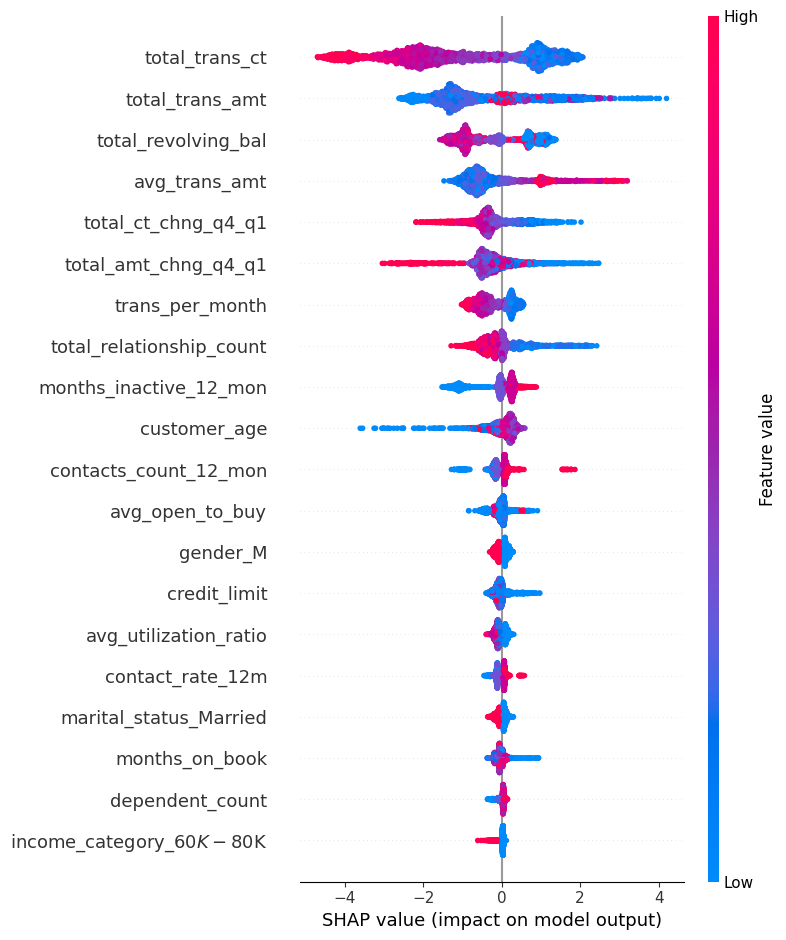

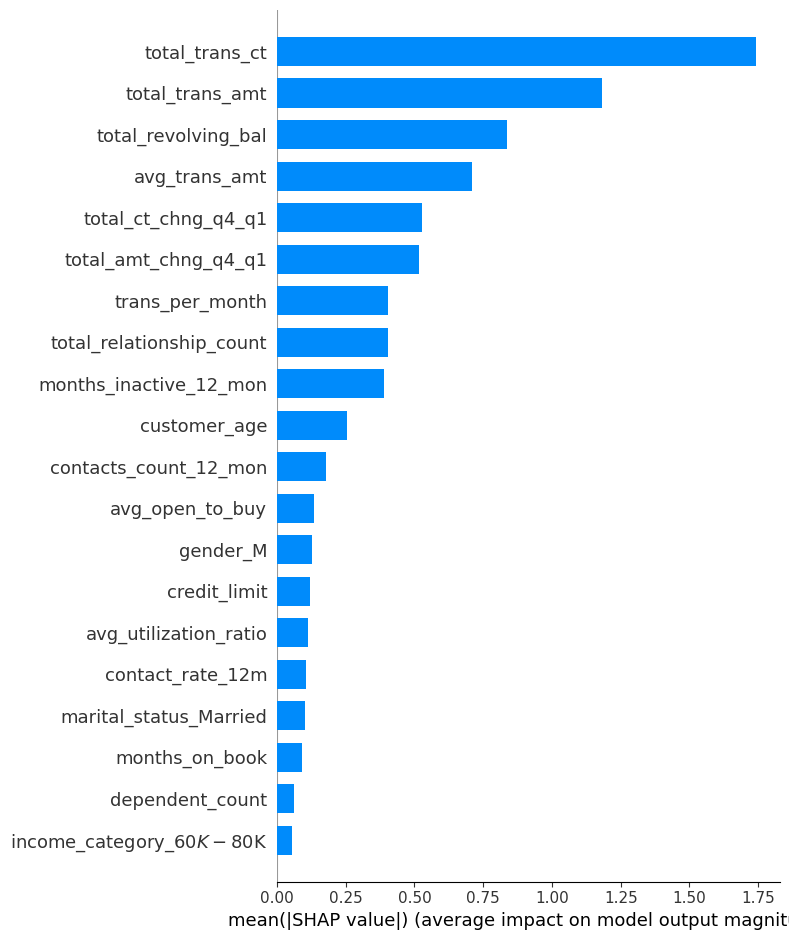

In [22]:
# === SHAP summary + bar: save AND display ===
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier  # or your chosen classifier
from pathlib import Path

OUT = Path("../outputs"); OUT.mkdir(exist_ok=True)

# Refit a compact model on encoded arrays for SHAP speed/clarity
enc_train = pre.transform(X_train)
enc_test  = pre.transform(X_test)

xgb_raw = XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    eval_metric="logloss", n_jobs=-1, random_state=42
)
xgb_raw.fit(enc_train, y_train)

# Feature names for encoded matrix
ohe = pre.named_transformers_["cat"]
ohe_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
feature_names = ohe_names + num_cols

explainer = shap.TreeExplainer(xgb_raw)
sv = explainer.shap_values(enc_test, check_additivity=False)

# 1) Summary (beeswarm)
shap.summary_plot(sv, features=enc_test, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(OUT / "churn_shap_summary.png", dpi=150)
plt.show()     # <-- display in notebook

# 2) Global importance (bar)
shap.summary_plot(sv, features=enc_test, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(OUT / "churn_shap_bar.png", dpi=150)
plt.show()     # <-- display in notebook


## Persist scored test set (for ROI / Tableau)

We’ll carry forward:
- `id`, `churn_true`, and **calibrated probability** (`p_churn`)
- A couple of useful slice dimensions (if present) for Tableau (e.g., `geography`, `gender`, `age`).

In [21]:
p_final = p_te_cal if 'p_te_cal' in globals() else (p_te_xgb if HAS_XGB else p_te)

dims = []
for c in ["geography","gender","customer_age","isactivemember","credit_score","balance","tenure"]:
    if c in X_test.columns: dims.append(c)

scored = pd.DataFrame({
    "id": X_test["id"].values if "id" in X_test.columns else np.arange(len(p_final)),
    "churn_true": y_test,
    "p_churn": p_final
})
scored = pd.concat([scored, X_test[dims].reset_index(drop=True)], axis=1)

scored.to_csv(PROC / "test_scored.csv", index=False)
print("Saved:", (PROC / "test_scored.csv").as_posix(), "→", scored.shape)


Saved: ../data/processed/test_scored.csv → (2532, 5)


## Export Drivers for Tableau (SHAP Global Importance)

**What this does.** Trains a compact XGBoost model on the encoded test set, computes **mean |SHAP| values** per feature, and saves a dashboard-ready table to `tableau/shap_importance.csv`.

**Why it matters.** This gives stakeholders a transparent, model-consistent view of the **top drivers of churn risk** (global importance), which feeds the “Drivers” bar chart in the Tableau one-pager.

**Output.**
- `tableau/shap_importance.csv` → columns: `feature`, `importance`

> Note: Feature importance reflects association within the model, **not causality**. Validate messaging and incentives with an A/B test before rollout.


In [25]:
import numpy as np, pandas as pd, shap
from pathlib import Path
from xgboost import XGBClassifier

TAB = Path("../tableau"); TAB.mkdir(exist_ok=True)

# Encode once for SHAP speed
enc_train = pre.transform(X_train)
enc_test  = pre.transform(X_test)

# Compact tree model purely for SHAP explanations
xgb_raw = XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    eval_metric="logloss", n_jobs=-1, random_state=42
)
xgb_raw.fit(enc_train, y_train)

# Feature names for encoded matrix
ohe = pre.named_transformers_["cat"]
ohe_names = list(ohe.get_feature_names_out(cat_cols)) if cat_cols else []
feature_names = ohe_names + num_cols

# SHAP values and global importance
explainer = shap.TreeExplainer(xgb_raw)
sv = explainer.shap_values(enc_test, check_additivity=False)          # shape: [n_samples, n_features]
imp = pd.DataFrame({
    "feature": feature_names,
    "importance": np.mean(np.abs(sv), axis=0)
}).sort_values("importance", ascending=False)

imp.to_csv(TAB/"shap_importance.csv", index=False)
print("Wrote:", (TAB/"shap_importance.csv").as_posix())


Wrote: ../tableau/shap_importance.csv


### Next (Step 4): Profit-optimal decisioning

- Convert probabilities to action: **targeting curve** (rank by `p_churn`)
- Choose **coverage** where cumulative expected profit **peaks**
- **Sensitivity**: offer cost × lift grid to show risk envelope
- Export CSVs for **Tableau** and render a one-pager dashboard
